## Monte Carlo Tree Search for Tic-Tac-Toe

### Peter Racioppo

In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams

import random
import math
from scipy.linalg import eig

### Basic board functionality and a function to play random games:

In [2]:
# This function plots the tic-tac-toe board:
def f_Plot_board(M, Winner):
    # Inputs:
    # M, a matrix which keeps track of pieces on the board
    # Winner, an indicator for who one (1 for X, -1 for O, 0 for draw)
    
    # Print who won:
    if Winner == 1:
        print("X wins!")
    elif Winner == -1:
        print("O wins!")
    else:
        print("Draw!")
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    plt.gca().set_aspect('equal', adjustable='box')
    
    # Loop through the boxes in the grid and plot the pieces on the board:
    # Note: Our matrix is indexed from left to right and from top to bottom,
    # but our board is indexed from left to right and from bottom to top.
    n = np.shape(M)[0]
    for i in np.arange(n):
        for j in np.arange(n):
            if M.T[i,n-1-j] == 1:
                plt.scatter(i+0.5,j+0.5,s=100,c="r",marker="x")
            elif M.T[i,n-1-j] == -1:
                plt.scatter(i+0.5,j+0.5,s=100,marker="o",facecolors='none', edgecolors='b')
    
    plt.xlim(0, n)
    plt.ylim(0, n)
    major_ticks = np.arange(0, n+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_yticks(major_ticks)
    ax.grid(which='both')
    plt.show()

In [4]:
# Plays a random game of Tic-tac-toe on an n x n board:
def f_Rand_TTT(n=3):
    # Input: n, the board dimension.
    
    pos = list(range(n**2)) # List of possible moves

    # v is a list version of the matrix representing the board.
    # It holds the moves that have been made in each position:
    # 1 for X, -1 for O, 0 for no piece.
    v = np.zeros(n**2)
    # While there is a valid move:
    for i in np.arange(n**2):
        move = np.random.choice(pos) # Choose a random move from the remaining possibilities
        idx = pos.index(move)
        del pos[idx] # Remove our new move from the list of possibilities
        # Append the move to the list of moves:
        if np.mod(i,2) == 0:
            v[move] = 1
        else:
            v[move] = -1

        # Check if someone won:
        M = np.reshape(v,[n,n]) # Reshape the list to a matrix
        Winner = 0 # Default to draw
        # If X occupies an entire row or an entire column or the main diagonal or the off diagonal, X wins:
        if n in M.sum(axis=1) or n in M.sum(axis=0) or np.trace(M) == n or np.trace(np.fliplr(M)) == n:
            Winner = 1
            break
        # If O occupies an entire row or an entire column or the main diagonal or the off diagonal, O wins:
        elif -n in M.sum(axis=1) or -n in M.sum(axis=0) or np.trace(M) == -n or np.trace(np.fliplr(M)) == -n:
            Winner = -1
            break

    # Outputs:
    # M, a matrix which keeps track of pieces on the board
    # Winner, an indicator for who one (1 for X, -1 for O, 0 for draw)
    return M, Winner

X wins!


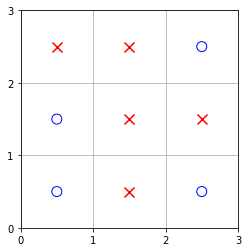

[[ 1.  1. -1.]
 [-1.  1.  1.]
 [-1.  1. -1.]]


In [5]:
# Play a Random Game:
n = 3
M, Winner = f_Rand_TTT(n)
f_Plot_board(M,Winner)

print(M)

Draw!


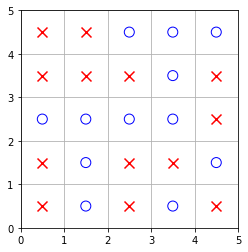

In [6]:
# Our functions support arbitrary board size:
n = 5
M, Winner = f_Rand_TTT(n)
f_Plot_board(M,Winner)

In [3]:
# Play N random games and calculate the percent won/lost/tied
def f_Play_N_Random_Games(N=1000,n=3):

    Win_Count = [] # Number of wins/losses/draws
    for i in np.arange(N):
        _, Winner = f_Rand_TTT(n) # Play a game and record Winner
        Win_Count.append(Winner) # Append Winner to list

    X_wins = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == 1)])[0] # Total number of wins for X
    O_wins = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == -1)])[0] # Total number of wins for O
    draws = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == 0)])[0] # Total number of draws

    percent_X_wins = 100*X_wins/N
    percent_O_wins = 100*O_wins/N
    percent_draws = 100*draws/N

    print("Percent X wins =", percent_X_wins, "%")
    print("Percent O wins =", percent_O_wins, "%")
    print("Percent draws =", percent_draws, "%")

In [8]:
f_Play_N_Random_Games(N=10000,n=3)

Percent X wins = 58.34 %
Percent O wins = 28.85 %
Percent draws = 12.81 %


### Player X (who goes first) wins about 60% of games. Player O (who goes second) wins about 30% of games. This will be our baseline performance.

### Now we build a simple AI:

### Let's begin with a simple Monte Carlo search that considers only the next move and then plays random games starting from each possible next move. The random games are played with replacement. For each move, we compute the total number of wins minus the total number of losses in our random games. We then pick the move that maximizes the number of wins minus the number of losses. This process amounts to maximizing an empirical estimate of the expectation of winning.

In [4]:
# Plays a random game starting from a position
# specified by prev_x, prev_o, the positions where
# x's and o's have already been played.
def f_Rand_i(n,x_moves=[],o_moves=[]):

    pos_i = list(range(n**2)) # List of all possible moves
    prev_moves = x_moves + o_moves # List of all previous moves
    pos_i = list(np.delete(pos_i,prev_moves)) # Remove previous moves from possible moves

    v = np.zeros(n**2)
    v[x_moves] = 1
    v[o_moves] = -1
    
    M_i = np.reshape(v,[n,n]) # Reshape the list to a matrix
    
    Winner_i = 0
    for i in np.arange(np.shape(pos_i)[0]):
        move = np.random.choice(pos_i) # Choose a random move from the possibilities
        idx = pos_i.index(move)
        del pos_i[idx]
        if np.mod(i,2) == 0:
            v[move] = 1
            x_moves.append(move)
        else:
            v[move] = -1
            o_moves.append(move)

        # Check if someone won:
        M_i = np.reshape(v,[n,n]) # Reshape the list to a matrix
        if n in M_i.sum(axis=1) or n in M_i.sum(axis=0) or np.trace(M_i) == n or np.trace(np.fliplr(M_i)) == n:
            Winner_i = 1
            break
        elif -n in M_i.sum(axis=1) or -n in M_i.sum(axis=0) or np.trace(M_i) == -n or np.trace(np.fliplr(M_i)) == -n:
            Winner_i = -1
            break
            
    return x_moves, o_moves, M_i, Winner_i

In [14]:
# Test

n = 3
pos = list(range(n**2))
prev_moves = [0,1,2]
pos = list(np.delete(pos,prev_moves))
pos

[3, 4, 5, 6, 7, 8]

X wins!


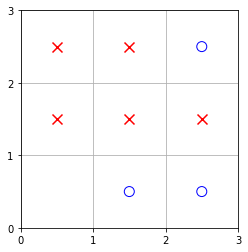

In [15]:
# Test

n = 3
x_moves = [0,1]
o_moves = [2]

x_moves, o_moves, M, Winner = f_Rand_i(n,x_moves,o_moves)
f_Plot_board(M,Winner)

In [5]:
# Appends a test_move to the list of moves that have already been made.
def f_Append_Test_Move(x_moves,o_moves,test_move,n):
    
    # Create copies to append the test value to:
    x_moves_test = list(np.empty_like(x_moves))
    o_moves_test = list(np.empty_like(o_moves))
    x_moves_test[:] = x_moves
    o_moves_test[:] = o_moves
    
    # If it's x's turn, append the test move to the list of x_moves
    # (x went first)
    if len(x_moves) <= len(o_moves):
        x_moves_test += [test_move]
    # If it's o's turn, append the test move to the list of o_moves
    else:
        o_moves_test += [test_move]
        
    return x_moves_test, o_moves_test

In [16]:
# Test

x_moves = [0,1]
o_moves = [2]

test_move = [np.random.choice(pos)] # Choose a test move at random
x_moves_test, o_moves_test = f_Append_Test_Move(x_moves,o_moves,test_move,n)
print(x_moves_test)
print(o_moves_test)

[0, 1]
[2, [4]]


In [6]:
# Branch, with replacement, from test move
def f_Branch_from_test_move(x_moves,o_moves,test_move,n=3,it=100):
    x_moves_test, o_moves_test = f_Append_Test_Move(x_moves,o_moves,test_move,n)
    count = 0
    for i in np.arange(it):
        x_moves_i = list(np.empty_like(x_moves_test))
        o_moves_i = list(np.empty_like(o_moves_test))
        x_moves_i[:] = x_moves_test
        o_moves_i[:] = o_moves_test
        _, _, _, Winner_i = f_Rand_i(n,x_moves_i,o_moves_i)
        count += Winner_i

    return count

In [7]:
# Given a list of possible moves, we consider
# all posibilites for the next move. We then
# randomly branch on each of these moves,
# and return the number of wins minus the
# number of losses for each.
def f_Monte_Carlo_Outcomes(pos,x_moves,o_moves,n,it=100):
    pos_test = list(np.empty_like(pos))
    pos_test[:] = pos
    L = np.shape(pos_test)[0]
    Count_v = np.zeros(L)

    for l in np.arange(L):
        test_move = pos_test[l]
        count = f_Branch_from_test_move(x_moves,o_moves,test_move,n=n,it=it)
        Count_v[l] = count

    return Count_v

In [55]:
Count_v = f_Monte_Carlo_Outcomes(pos,x_moves,o_moves,n)
print(Count_v)

[ 41. -31.  14.  -8.  33.  -9.]


In [21]:
# Test
# In what percent of games does X choose the center position as the first move?

n = 3
it = 100
O_mode = 0
X_mode = 1

counter = 0
iterations = 100

pos = list(range(n**2)) # List of all possible moves

for i in np.arange(iterations):

    x_moves = []
    o_moves = []

    if (len(x_moves) <= len(o_moves)) and X_mode == 1:
        Count_v = f_Monte_Carlo_Outcomes(pos,x_moves,o_moves,n,it)
        idx = np.argmax(Count_v)
    elif (len(x_moves) > len(o_moves)) and O_mode == 1:
        Count_v = f_Monte_Carlo_Outcomes(pos,x_moves,o_moves,n,it)
        idx = np.argmin(Count_v)
    else:
        idx = np.random.choice(np.arange(np.shape(pos)[0]))

    new_move = pos[idx]

    if new_move == 4:
        counter += 1
        
print(counter/iterations)

0.89


### Player 1 chooses the center box as its first move about 90% of the time.

In [8]:
# Plays a game of Tic-tac-toe on an n x n board,
# using a pure Monte Carlo search algorithm.
def f_Monte_Carlo_TTT(X_mode,O_mode,n=3,it=100):
    # Inputs:
    # X_mode = 1 for Monte Carlo algorithm, X_mode = 0 for random play
    # O_mode = 1 for Monte Carlo algorithm, O_mode = 0 for random play
    # n, the board dimension.
    # it, the number of MC simulations for each test move

    pos = list(range(n**2)) # List of possible moves

    # v is a list version of the matrix representing the board.
    # It holds the moves that have been made in each position:
    # 1 for X, -1 for O, 0 for no piece.
    v = np.zeros(n**2)

    x_moves = []
    o_moves = []

    Winner = 0 # Default to draw
    
    # While there is a valid move:
    for i in np.arange(n**2):
        if np.mod(i,2) == 0 and X_mode == 1:
            Count_v = f_Monte_Carlo_Outcomes(pos,x_moves,o_moves,n,it)
            idx = np.argmax(Count_v)
        elif np.mod(i,2) == 1 and O_mode == 1:
            Count_v = f_Monte_Carlo_Outcomes(pos,x_moves,o_moves,n,it)
            idx = np.argmin(Count_v)
        else:
            idx = np.random.choice(np.arange(np.shape(pos)[0]))

        new_move = pos[idx]
        del pos[idx]

        # Append the move to the list of moves:
        if np.mod(i,2) == 0:
            x_moves += [new_move]
            v[new_move] = 1
        else:
            o_moves += [new_move]
            v[new_move] = -1

        # Check if someone won:
        M = np.reshape(v,[n,n]) # Reshape the list to a matrix
        # If X occupies an entire row or an entire column or the main diagonal or the off diagonal, X wins:
        if n in M.sum(axis=1) or n in M.sum(axis=0) or np.trace(M) == n or np.trace(np.fliplr(M)) == n:
            Winner = 1
            break
        # If O occupies an entire row or an entire column or the main diagonal or the off diagonal, O wins:
        elif -n in M.sum(axis=1) or -n in M.sum(axis=0) or np.trace(M) == -n or np.trace(np.fliplr(M)) == -n:
            Winner = -1
            break

    # Outputs:
    # M, a matrix which keeps track of pieces on the board
    # Winner, an indicator for who won (1 for X, -1 for O, 0 for draw)
    return M, Winner

X wins!


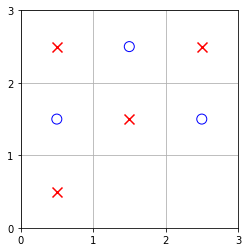

In [9]:
M, Winner = f_Monte_Carlo_TTT(X_mode=1,O_mode=0,n=3,it=100)
f_Plot_board(M,Winner)

O wins!


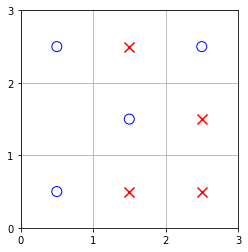

In [10]:
M, Winner = f_Monte_Carlo_TTT(X_mode=0,O_mode=1,n=3,it=10)
f_Plot_board(M,Winner)

X wins!


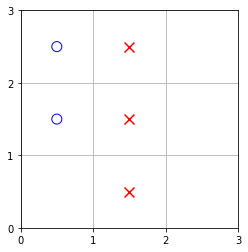

In [12]:
M, Winner = f_Monte_Carlo_TTT(X_mode=1,O_mode=1,n=3,it=10)
f_Plot_board(M,Winner)

In [9]:
# Play N games and calculate the percent won/lost/tied
# (using a random Monte Carlo search)
def f_Play_N_Games(X_mode,O_mode,n=3,it=100,N=100):

    Win_Count = [] # Number of wins/losses/draws
    for i in np.arange(N):
        _, Winner = f_Monte_Carlo_TTT(X_mode=X_mode,O_mode=O_mode,n=n,it=it) # Play a game and record Winner
        Win_Count.append(Winner) # Append Winner to list

    X_wins = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == 1)])[0] # Total number of wins for X
    O_wins = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == -1)])[0] # Total number of wins for O
    draws = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == 0)])[0] # Total number of draws

    percent_X_wins = 100*X_wins/N
    percent_O_wins = 100*O_wins/N
    percent_draws = 100*draws/N

    print("Percent X wins =", percent_X_wins, "%")
    print("Percent O wins =", percent_O_wins, "%")
    print("Percent draws =", percent_draws, "%")

__________________________

### We now test the algorithm by simulating tournaments.

### 10,000 games with both players playing randomly:

In [801]:
f_Play_N_Games(X_mode=0,O_mode=0,n=3,it=100,N=10000)

Percent X wins = 58.15 %
Percent O wins = 29.04 %
Percent draws = 12.81 %


__________________________

### 100 games with X using the Monte Carlo algorithm and O playing randomly:

In [802]:
f_Play_N_Games(X_mode=1,O_mode=0,n=3,it=100,N=100)

Percent X wins = 91.0 %
Percent O wins = 7.0 %
Percent draws = 2.0 %


In [804]:
f_Play_N_Games(X_mode=1,O_mode=0,n=3,it=10,N=100)

Percent X wins = 88.0 %
Percent O wins = 12.0 %
Percent draws = 0.0 %


### Decreasing the number of Markov chains per simulation from 100 to 10 seems to only marginally worsen performance.

__________________________

### 100 games with O using the Monte Carlo algorithm and X playing randomly:

In [13]:
f_Play_N_Games(X_mode=0,O_mode=1,n=3,it=100,N=100)

Percent X wins = 2.0 %
Percent O wins = 74.0 %
Percent draws = 24.0 %


### When 10 Markov chains are used, O wins about 70% of the time.

In [809]:
f_Play_N_Games(X_mode=0,O_mode=1,n=3,it=10,N=100)

Percent X wins = 12.0 %
Percent O wins = 71.0 %
Percent draws = 17.0 %


__________________________

### 100 games with both players using the Monte Carlo algorithm:

In [787]:
f_Play_N_Games(X_mode=1,O_mode=1,n=3,it=10,N=100)

Percent X wins = 49.0 %
Percent O wins = 40.0 %
Percent draws = 11.0 %


### With both players using the Monte Carlo algorithm, X still wins more, due to its starting advantage, but its advantage is much smaller than in the random case.

______

### To improve the algorithm, we can progressively narrow the window of the Monte Carlo search to spend extra time searching on the most promising moves, first searching over all n moves, then the best n/k moves, then the best n/k^2 moves, and so on.

In [178]:
# Plays a game of Tic-tac-toe on an n x n board,
# using a pure Monte Carlo search algorithm.
# Allows for the window for the Monte Carlo search
# to be progressively decreased in size.
def f_Exp_Window_Monte_Carlo_TTT(X_mode,O_mode,n=3,window=1,it=100):
    # Inputs:
    # X_mode = 1 for Monte Carlo algorithm, X_mode = 0 for random play
    # O_mode = 1 for Monte Carlo algorithm, O_mode = 0 for random play
    # n, the board dimension.
    # window, the number of windows to use in search. window = 1 for 1 MC search,
    # window = 2 for a repeated search on the 4 best moves, window = 3 for a third
    # search on the best 2 moves.
    # it, the number of MC simulations for each test move

    pos = list(range(n**2)) # List of possible moves

    # v is a list version of the matrix representing the board.
    # It holds the moves that have been made in each position:
    # 1 for X, -1 for O, 0 for no piece.
    v = np.zeros(n**2)

    x_moves = []
    o_moves = []

    Winner = 0 # Default to draw
    
    # While there is a valid move:
    for i in np.arange(n**2):
        if np.mod(i,2) == 0 and X_mode == 1:
            Count_v = f_Monte_Carlo_Outcomes(pos,x_moves,o_moves,n,it)
            # If there are at least 4 possible moves remaining,
            # repeat the pure Monte Carlo search on the 4 best moves.
            if np.shape(Count_v)[0] > 4 and window >= 2:
                idxs = np.flip(np.argsort(np.array(Count_v)))[0:4]
                pos_i = np.array(pos)[idxs]
                Count_v = f_Monte_Carlo_Outcomes(pos_i,x_moves,o_moves,n,it)
                # If there are at least 2 possible moves remaining,
                # repeat the pure Monte Carlo search on the 2 best moves.
                if np.shape(Count_v)[0] > 2 and window >= 3:
                    idxs2 = np.flip(np.argsort(np.array(Count_v)))[0:2]
                    pos_i = np.array(pos)[idxs2]
                    Count_v = f_Monte_Carlo_Outcomes(pos_i,x_moves,o_moves,n,it)
                    idxk = np.argmax(Count_v)
                    idxj = idxs2[idxk]
                else:
                    idxj = np.argmax(Count_v)
                idx = idxs[idxj]
            else:
                idx = np.argmax(Count_v)
        elif np.mod(i,2) == 1 and O_mode == 1:
            Count_v = f_Monte_Carlo_Outcomes(pos,x_moves,o_moves,n,it)
            # If there are at least 4 possible moves remaining,
            # repeat the pure Monte Carlo search on the 4 best moves.
            if np.shape(Count_v)[0] >= 4 and window >= 2:
                idxs = np.argsort(np.array(Count_v))[0:4]
                pos_i = np.array(pos)[idxs]
                Count_v = f_Monte_Carlo_Outcomes(pos_i,x_moves,o_moves,n,it)
                # If there are at least 2 possible moves remaining,
                # repeat the pure Monte Carlo search on the 2 best moves.
                if np.shape(Count_v)[0] >= 2 and window >= 3:
                    idxs2 = np.argsort(np.array(Count_v))[0:2]
                    pos_i = np.array(pos)[idxs2]
                    Count_v = f_Monte_Carlo_Outcomes(pos_i,x_moves,o_moves,n,it)
                    idxk = np.argmin(Count_v)
                    idxj = idxs2[idxk]
                else:
                    idxj = np.argmin(Count_v)
                idx = idxs[idxj]
            else:
                idx = np.argmin(Count_v)
        else:
            idx = np.random.choice(np.arange(np.shape(pos)[0]))
        
        new_move = pos[idx]
        del pos[idx]

        # Append the move to the list of moves:
        if np.mod(i,2) == 0:
            x_moves += [new_move]
            v[new_move] = 1
        else:
            o_moves += [new_move]
            v[new_move] = -1

        # Check if someone won:
        M = np.reshape(v,[n,n]) # Reshape the list to a matrix
        # If X occupies an entire row or an entire column or the main diagonal or the off diagonal, X wins:
        if n in M.sum(axis=1) or n in M.sum(axis=0) or np.trace(M) == n or np.trace(np.fliplr(M)) == n:
            Winner = 1
            break
        # If O occupies an entire row or an entire column or the main diagonal or the off diagonal, O wins:
        elif -n in M.sum(axis=1) or -n in M.sum(axis=0) or np.trace(M) == -n or np.trace(np.fliplr(M)) == -n:
            Winner = -1
            break

    # Outputs:
    # M, a matrix which keeps track of pieces on the board
    # Winner, an indicator for who won (1 for X, -1 for O, 0 for draw)
    return M, Winner

In [150]:
# Compute the percentage of games in which X plays the center position as its first move:

iterz = 100
count = 0
for i in np.arange(iterz):
    M, Winner = f_Exp_Window_Monte_Carlo_TTT(X_mode=1,O_mode=1,n=3,it=10)

    if M[1,1] == 1:
        count += M[1,1]
count/iterz

57.0

In [165]:
# Play N random games and calculate the percent won/lost/tied
# (using the windowed-version of the Monte Carlo search)
def f_Play_N_Games2(X_mode,O_mode,n=3,it=100,window=1,N=100):

    Win_Count = [] # Number of wins/losses/draws
    for i in np.arange(N):
        _, Winner = f_Exp_Window_Monte_Carlo_TTT(X_mode=X_mode,O_mode=O_mode,n=n,window=window,it=it) # Play a game and record Winner
        Win_Count.append(Winner) # Append Winner to list

    X_wins = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == 1)])[0] # Total number of wins for X
    O_wins = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == -1)])[0] # Total number of wins for O
    draws = np.shape(np.array(Win_Count)[np.where(np.array(Win_Count) == 0)])[0] # Total number of draws

    percent_X_wins = 100*X_wins/N
    percent_O_wins = 100*O_wins/N
    percent_draws = 100*draws/N

    print("Percent X wins =", percent_X_wins, "%")
    print("Percent O wins =", percent_O_wins, "%")
    print("Percent draws =", percent_draws, "%")

In [176]:
f_Play_N_Games2(X_mode=1,O_mode=0,n=3,it=100,window=1,N=100)

Percent X wins = 95.0 %
Percent O wins = 5.0 %
Percent draws = 0.0 %


In [158]:
f_Play_N_Games2(X_mode=1,O_mode=0,n=3,it=100,window=2,N=100)

Percent X wins = 95.0 %
Percent O wins = 4.0 %
Percent draws = 1.0 %


In [153]:
f_Play_N_Games2(X_mode=1,O_mode=0,n=3,it=100,window=3,N=100)

Percent X wins = 90.0 %
Percent O wins = 10.0 %
Percent draws = 0.0 %


In [177]:
f_Play_N_Games2(X_mode=0,O_mode=1,n=3,it=100,window=1,N=100)

Percent X wins = 1.0 %
Percent O wins = 76.0 %
Percent draws = 23.0 %


In [160]:
f_Play_N_Games2(X_mode=0,O_mode=1,n=3,it=100,window=2,N=100)

Percent X wins = 3.0 %
Percent O wins = 65.0 %
Percent draws = 32.0 %


In [154]:
f_Play_N_Games2(X_mode=0,O_mode=1,n=3,it=100,window=3,N=100)

Percent X wins = 18.0 %
Percent O wins = 63.0 %
Percent draws = 19.0 %


In [ ]:
# The window method actually seems to make things worse.